In [1]:
exec(open("./MAB_class.py").read())
import math
import random
import scipy
import numpy as np
import scipy.integrate as integrate  
from scipy.stats import beta
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import re
import os
import timeit

In [15]:
def test_algorithm(algo, arms, num_sims, horizon,k=1,m=1):
    '''Run Monte Carlo simulation for each bandit algorithm with different scenarios.
       algo:     list of testing bandit algorithms
       arms:     list of the total n arms
       num_sims: int, # of simulations
       horizon:  int,  # of bandit steps per simulation
       k:        int, default is 1, which is the traditional multi-armed bandit. Select k arms out of n at each step.
       m:        int, size of batch update between each step. Default is 1.'''
    # initialization
    if k<=1:
        chosen_arms = [0.0 for i in range(num_sims * horizon)] 
    else:
        chosen_arms = [np.zeros(k) for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)] 
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)] 
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    
    ##Monte Carlo simulation
    for sim in range(num_sims): 
        sim=sim+1 
        algo.initialize(len(arms))
        for t in range(horizon):
            t=t+1 
            index=(sim-1)*horizon+t-1
            sim_nums[index] = sim
            times[index] = t
            reward=[0.0 for i in range(k)]
            if k<=1:
                chosen_arm = algo.select_arm()
                for i in range(m):
                    reward[k-1] +=arms[chosen_arm].draw()                   
            else:
                chosen_arm = algo.select_k_arm(k)
                for i in range(m):
                    for j in range(k):
                        reward[j] +=arms[chosen_arm[j]].draw()
            chosen_arms[index] = chosen_arm
            rewards[index] = float(sum(reward)/m)
            if t==1: 
                cumulative_rewards[index] = float(sum(reward)/m)
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + float(sum(reward)/m)
            if k<=1:
                algo.update(chosen_arm, float(sum(reward)/m))
            else:
                arms_impression=np.zeros(len(arms))
                updated_reward=np.zeros(len(arms))
                for j in range(k):
                    arms_impression[chosen_arm[j]]=m
                    updated_reward[chosen_arm[j]]=reward[j]
                algo.batch_update(arms_impression, updated_reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]



In [3]:
##Set bernouli arms success rate
means = [0.01, 0.012, 0.0093, 0.004, 0.009]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

##Set algorithm list. 
algos={}
algo_candidates=[Softmax,UCB1,Thompson_Sampling,AnnealingSoftmax,EpsilonGreedy]
for candidate in algo_candidates:
    algos[candidate.__name__]=candidate([],[])
    print("alg",str(candidate.__name__))
##EpsilonGreedy with epsilon=1 is compeletely random strategy.
algos['EpsilonGreedy'].set_epsilon_greedy(1)

alg Softmax
alg UCB1
alg Thompson_Sampling
alg AnnealingSoftmax
alg EpsilonGreedy


In [4]:
# Check performance of 'test_algorithm'

#start = timeit.default_timer()
#test_algorithm(alg_Softmax, arms, 5000, 2500,k=2, m=10)
#stop = timeit.default_timer()

#print(stop - start)




In [5]:
FILEDIR="/home/knie/bandit_result"

def auto_file(num_sims=5000, horizon=2500, file_name=None, file_dir=FILEDIR, k=1, m=1):
    '''Auto generate and return file name and file path. Default file-name: bandit_5000_2500_1_1'''
    
    if not os.path.isdir(file_dir):
        os.makedirs(file_dir)
    if not file_name:
        ##default file name generator format: bandit_5000_2500_1_1
        file_name='bandit'+'_'+str(num_sims)+'_'+str(horizon)+'_'+str(k)+'_'+str(m)
    file_path= os.path.join(file_dir, file_name)
    return file_name,file_path

def Simulation_savefile(algo_pool, ARMS, num_sims=5000, horizon=2500, file_path=None, k=1, m=1):
    '''A wrapper of "test_algorithm" to test all algorithm in list of "algo_pool" based on list of "ARMS". 
       Save the result in "file_path"'''
    
    if not file_path:
        print ("please set file_path=")
        return
    print("Results to be saved in", file_path)
    f=open(file_path, "w")
    
    for algo_name, candidate in algo_pool.items():
        results = test_algorithm(candidate, ARMS, num_sims=num_sims, horizon=horizon, k=k, m=m) 
        for i in range(len(results[0])):
            f.write(algo_name + "\t")
            f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
    f.close()  
    
    
def draw_bestarm_fig (df,k=1,file_name=None, bernouli_arms=None):
    '''Draw the figure showing Monte Carlo results'''
    
    top_k=sorted(np.argpartition(np.array(means),len(means)-k)[-k:])
    df['best_arm_yn']=df['chosen_arms'].apply(lambda x: int(sorted(np.fromstring(re.sub('\]|\[', '', str(x)),sep=' '))==top_k))
    data=df.groupby(['method','times'], as_index=False)
    data=data.mean().reset_index()
    data['method']=data['method'].astype(str)
    fig, ax = plt.subplots()
    for key, grp in data.groupby(['method']):
        ax = grp.plot(ax=ax, kind='line', x='times', y='best_arm_yn', label=key)
    plt.legend(loc='best')
    ax.set_ylabel('Prob of choosing best arm')
    if file_name:
        _,simu_n,horizon,k,m=file_name.split("_")
        ax.set_title(r"sim="+simu_n+r"; horizon="+horizon+r"; k="+k+r";m="+m)
    if not bernouli_arms:
        print("SET ARMS please!")
        return
    else:
        plt.suptitle("arms:"+str(bernouli_arms))
    plt.show()

# With arms success rates= [0.1, 0.2, 0.3, 0.4, 0.9], simulate 2400 steps with 5000 simulations.

In [6]:
##Set bernouli arms success rate
means = [0.1, 0.2, 0.3, 0.4, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

##Set algorithm list. 
algos={}
algo_candidates=[Softmax,UCB1,Thompson_Sampling,AnnealingSoftmax,EpsilonGreedy]
for candidate in algo_candidates:
    algos[candidate.__name__]=candidate([],[])
    print("alg",str(candidate.__name__))
##EpsilonGreedy with epsilon=1 is compeletely random strategy.
algos['EpsilonGreedy'].set_epsilon_greedy(1)

alg Softmax
alg UCB1
alg Thompson_Sampling
alg AnnealingSoftmax
alg EpsilonGreedy


##1. k=1, m=1

num_sims= 5000 horizon= 2400 k= 1 m= 1 
Arms success rates= [0.3, 0.9, 0.1, 0.2, 0.4]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_1_1
729.9517698227428


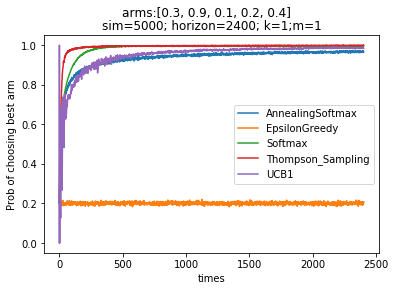

In [7]:
num_sims, horizon, k, m=5000, 2400, 1, 1
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims, horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t', names=['method',
                                            'sim_nums', 
                                            'times', 
                                            'chosen_arms', 
                                            'rewards', 
                                            'cumulative_rewards'])
draw_bestarm_fig(df, k=k, file_name=file_name, bernouli_arms=means)




##2. k=1, m=10

num_sims= 5000 horizon= 2400 k= 1 m= 10 
Arms success rates= [0.3, 0.9, 0.1, 0.2, 0.4]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_1_10
1513.336711937096


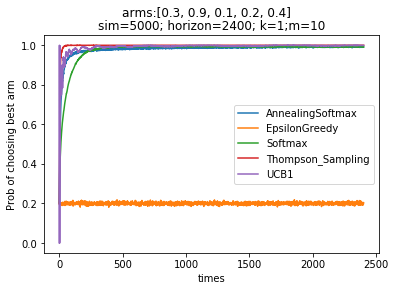

In [8]:
num_sims, horizon, k, m=5000, 2400, 1, 10
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

##3. k=1, m=100

num_sims= 5000 horizon= 2400 k= 1 m= 100 
Arms success rates= [0.3, 0.9, 0.1, 0.2, 0.4]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_1_100
3102.4772448660806


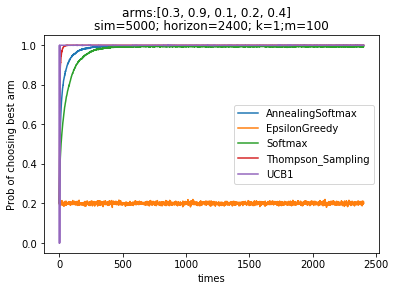

In [9]:
num_sims, horizon, k, m=5000, 2400, 1, 100
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

##4. k=2, m=1

num_sims= 5000 horizon= 2400 k= 2 m= 1 
Arms success rates= [0.3, 0.9, 0.1, 0.2, 0.4]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_2_1
7067.506253417116


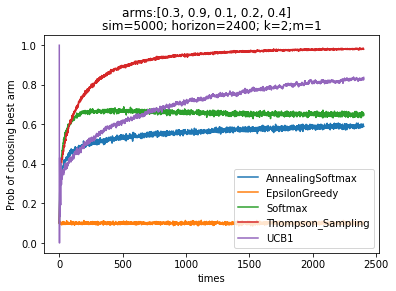

In [16]:
num_sims, horizon, k, m=5000, 2400, 2, 1
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

In [14]:
algos['Thompson_Sampling'].counts, algos['Thompson_Sampling'].values

([0.0, 6.0, 5.0, 1.0, 2.0], [0.0, 1.1666666666666667, 1.0, 1.0, 1.5])

In [12]:
[int(algos['Thompson_Sampling'].counts[i]*algos['Thompson_Sampling'].values[i]+0.5) for i in range(5)]

[0, 7, 5, 1, 3]

In [ ]:
sucess=[int(self.counts[i]*self.values[i]+0.5) for i in range(n_arms)]
samples=[random.betavariate(self.BetaPrior_Alpha+sucess[i],self.BetaPrior_Beta+self.counts[i]-sucess[i]) for i in range(n_arms)]


##5. k=2, m=10

num_sims= 5000 horizon= 2400 k= 2 m= 10 
Arms success rates= [0.3, 0.9, 0.1, 0.2, 0.4]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_2_10
7903.196536659263


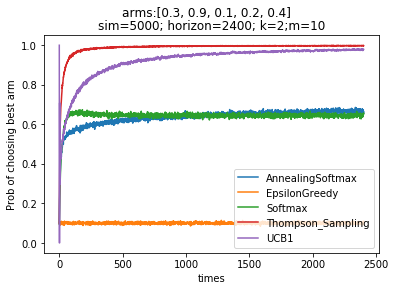

In [17]:
num_sims, horizon, k, m=5000, 2400, 2, 10
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

##6. k=2, m=100

num_sims= 5000 horizon= 2400 k= 2 m= 100 
Arms success rates= [0.3, 0.9, 0.1, 0.2, 0.4]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_2_100
14159.028122064192


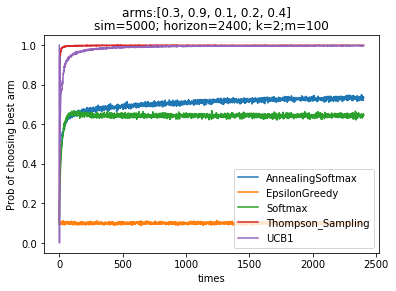

In [18]:
num_sims, horizon, k, m=5000, 2400, 2, 100
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

# With Arms success rates= [0.004, 0.01, 0.0093, 0.012, 0.009], simulate 2500 steps with 5000 simulations.

In [19]:
##Set bernouli arms success rate
means = [0.01, 0.012, 0.0093, 0.004, 0.009]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

##Set algorithm list. 
algos={}
algo_candidates=[Softmax,UCB1,Thompson_Sampling,AnnealingSoftmax,EpsilonGreedy]
for candidate in algo_candidates:
    algos[candidate.__name__]=candidate([],[])
    print("alg",str(candidate.__name__))
##EpsilonGreedy with epsilon=1 is compeletely random strategy.
algos['EpsilonGreedy'].set_epsilon_greedy(1)

alg Softmax
alg UCB1
alg Thompson_Sampling
alg AnnealingSoftmax
alg EpsilonGreedy


##1. k=1, m=1

num_sims= 5000 horizon= 2400 k= 1 m= 1 
Arms success rates= [0.004, 0.012, 0.01, 0.0093, 0.009]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_1_1
800.4340841961093


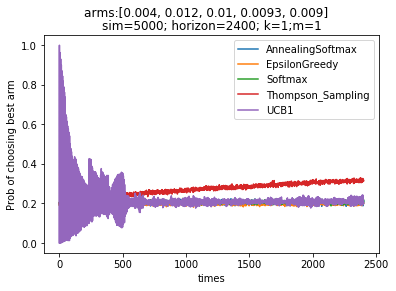

In [20]:
num_sims, horizon, k, m=5000, 2400, 1, 1
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

##2.  k=1, m=10 

num_sims= 5000 horizon= 2400 k= 1 m= 10 
Arms success rates= [0.004, 0.012, 0.01, 0.0093, 0.009]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_1_10
997.3827913729474


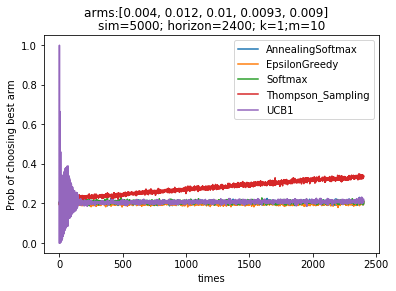

In [21]:
num_sims, horizon, k, m=5000, 2400, 1, 10
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

##3. k=1, m=100

num_sims= 5000 horizon= 2400 k= 1 m= 100 
Arms success rates= [0.004, 0.012, 0.01, 0.0093, 0.009]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_1_100
2911.9281683512963


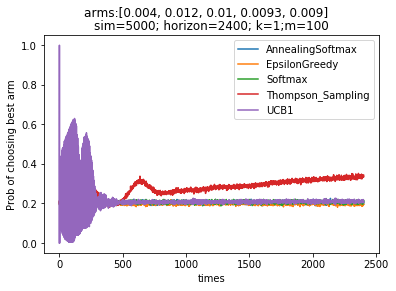

In [22]:
num_sims, horizon, k, m=5000, 2400, 1, 100
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

##4. k=2, m=1

num_sims= 5000 horizon= 2400 k= 2 m= 1 
Arms success rates= [0.004, 0.012, 0.01, 0.0093, 0.009]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_2_1
6794.982814498711


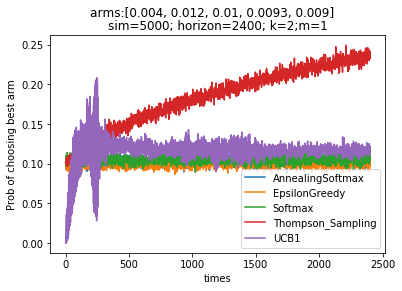

In [23]:
num_sims, horizon, k, m=5000, 2400, 2, 1
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

##5. k=2, m=10

num_sims= 5000 horizon= 2400 k= 2 m= 10 
Arms success rates= [0.004, 0.012, 0.01, 0.0093, 0.009]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_2_10
7477.053142052144


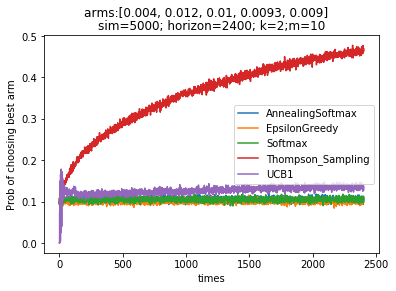

In [24]:
num_sims, horizon, k, m=5000, 2400, 2, 10
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

##6. k=2, m=100

In [ ]:
num_sims, horizon, k, m=5000, 2400, 2, 100
print("num_sims=",          num_sims, 
      "horizon=",           horizon, 
      "k=",                 k, 
      "m=",                 m, "\n" 
      "Arms success rates=",means)
start = timeit.default_timer()
file_name, f_path= auto_file(num_sims=num_sims,horizon=horizon, k=k, m=m)
Simulation_savefile(algos, arms, num_sims=num_sims, horizon=horizon, file_path=f_path, k=k, m=m )
stop = timeit.default_timer()
print(stop - start)

df = pd.read_table(f_path, sep='\t',names=['method','sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])
draw_bestarm_fig(df,k=k,file_name=file_name, bernouli_arms=means)

num_sims= 5000 horizon= 2400 k= 2 m= 100 
Arms success rates= [0.004, 0.012, 0.01, 0.0093, 0.009]
Results to be saved in /home/knie/bandit_result/bandit_5000_2400_2_100
